## НИУ ВШЭ НН. Факультет ИМиКН. Методы анализа данных. Charge de cours: В. А. Калягин
#### **Экзамен. Практика.**
#### **Вариант 19**. Выполнил: **Игорь Рухович**
#### Будут использованы: **PCA, K-means, Spectral clustering**

### Импортируем необходимые библиотеки

In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from mst_clustering import MSTClustering
import networkx as nx
from networkx.algorithms.community import modularity
from scipy.spatial import distance_matrix
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.mixture import GaussianMixture

### Код для чтения данных + общие переменные

In [2]:
data_path = "../data/"
filename = lambda number: f"22_MAG_Exam_Practice_{number}.xls"
variants = range(1, 22)
my_variant = 19
random_state = 123
columns = [
    "Age (years)",
    "Family size",
    "Monthly income (RUB)",
    "Residence in the region (years)",
    "Car valuation (USD)",
    "Loan amount (x1000 RUB)",
]
dtypes = [
    int,
    int,
    float,
    float,
    float,
    int,
]
types_dict = {elem[0]: elem[1] for elem in zip(columns, dtypes)}

def read_specific_variant(number: int) -> pd.DataFrame:
    return pd.read_excel(data_path + filename(number), header=None, names=columns)

### Первичный анализ

Рассмотрим данные:

Набор очень похож на набор из ДЗ1. Возьмём названия колонок оттуда для удобства.

In [5]:
df = read_specific_variant(my_variant)
df.head()

,Age (years),Family size,Monthly income (RUB),Residence in the region (years),Car valuation (USD),Loan amount (x1000 RUB)
0,51,3,18600,17,21000,200000
1,44,2,11300,13,12000,117000
2,28,0,8500,3,6000,67000
3,41,2,15800,11,16000,159000
4,42,2,8300,12,9000,84000


Соберём некоторые статистики: среднее, стандартное отклонение и каждый 25-й процентиль:

In [7]:
df.describe()

,Age (years),Family size,Monthly income (RUB),Residence in the region (years),Car valuation (USD),Loan amount (x1000 RUB)
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,39.985714,2.071429,20000.000000,9.957143,20014.285714,200014.285714
std,8.074818,1.026058,9999.391286,5.017175,9927.991255,100000.361283
min,20.000000,-1.000000,2600.000000,-2.000000,2000.000000,19000.000000
25%,34.250000,1.250000,11325.000000,6.250000,12000.000000,119750.000000
50%,39.000000,2.000000,20250.000000,9.000000,20000.000000,199500.000000
75%,46.500000,3.000000,26875.000000,14.000000,26750.000000,265750.000000
max,60.000000,5.000000,40300.000000,22.000000,43000.000000,422000.000000


Дополнительно построим гистограммы распределения и диаграммы размаха для каждого признака, чтобы лучше понять их структуру и распределение: 

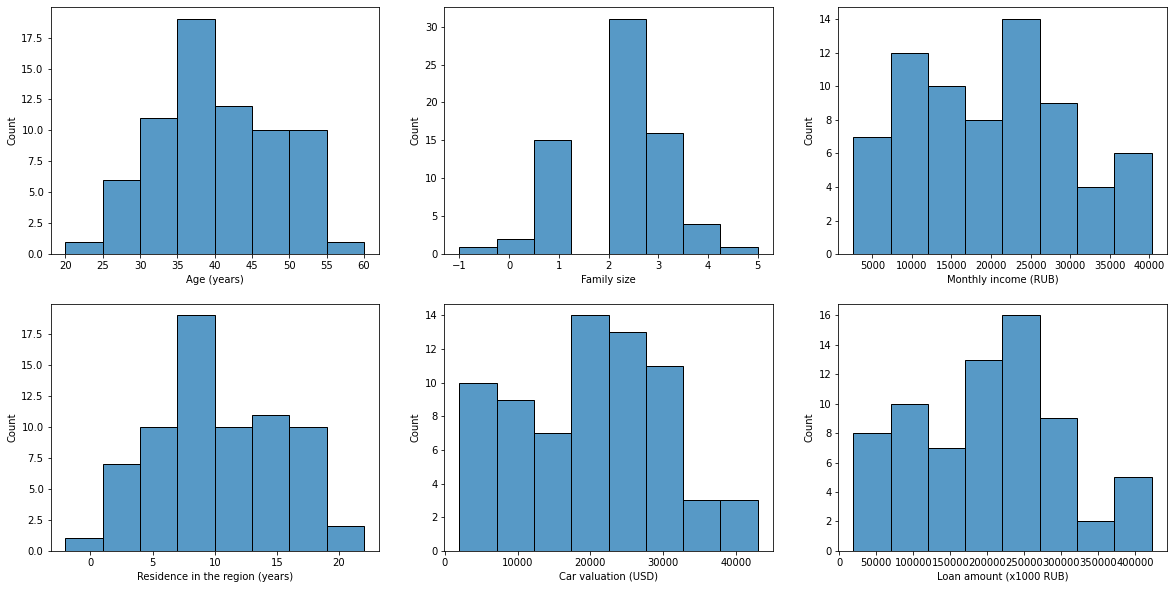

In [8]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20,10)

for i in range(6):
    sns.histplot(data=df, x=columns[i], ax=np.ravel(axs)[i])

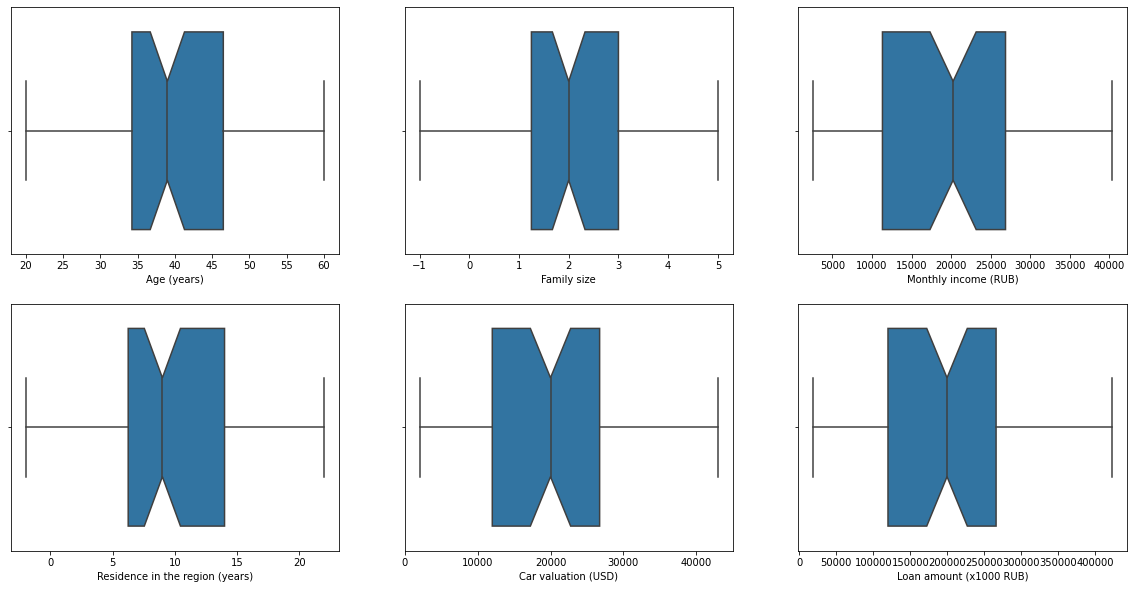

In [10]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20,10)

for i in range(6):
    sns.boxplot(data=df, x=columns[i], ax=np.ravel(axs)[i], notch=True, whis=1.5)

Визуально гистограммы распределения напоминаю нормальные или смесь нормальных, возможно, с некоторым шумом (в силу маленького объема).

Диаграммы размаха говорят о том, что бОльшая часть данных по всем признакам сосредоточена вокруг медианы - свойственно нормальному распределению.

Отдельно заметим, что все данные лежат на расстоянии  $\leq 1.5$ ширины "ящика" (`whis=1.5`), поскольку ни один из графиков не содержит "точек" за "усами"

Проверим наличие пропусков. Выведем процент пропусков по каждой колонке:

In [12]:
df.isna().sum() / df.shape[0] * 100

Age (years)                        0.0
Family size                        0.0
Monthly income (RUB)               0.0
Residence in the region (years)    0.0
Car valuation (USD)                0.0
Loan amount (x1000 RUB)            0.0
dtype: float64

Пропусков в данных нет.

Исходя из отсутствия "точек" за "усами" на диаграммах размаха (сказано выше), а также из приличного вида гистограмм распределения (нет пустых колонок по бокам), предположим, что выбросов нет и не будем их искать. Тем более, имея всего 70 объектов.

А вот что необходимо сделать - так это стандартизацию данных (избавляемся от среднего и приводим стандартное отклонение к 1). Видим, что колонки содержат совершенно разные порядки величин. Это может помешать некоторым алгоритмам в дальнейшем.

In [14]:
from sklearn.preprocessing import StandardScaler

z = StandardScaler().fit_transform(df)
print(f"Проверка центрирования (must be equal to 0):\n{z.mean(axis=0)}")
print(f"\nПроверка нормализации (must be equal to 1):\n{z.std(axis=0)}")

Проверка центрирования (must be equal to 0):
[-2.12528408e-16 -1.53052174e-16  3.17206578e-18 -1.58603289e-17
  5.39251183e-17  2.53765263e-17]

Проверка нормализации (must be equal to 1):
[1. 1. 1. 1. 1. 1.]


### Снижение размерности

Чтобы оценить возможность снижения размерности и погрешность такого подхода, применим спектральное разложение (SVD) из реализации numpy:

In [15]:
u, s, vt = np.linalg.svd(z, full_matrices=False)
print(f"Сингулярные числа исходной матрицы:\n{s}")

Сингулярные числа исходной матрицы:
[14.87867643 13.95265009  1.93464481  0.41758925  0.17452334  0.02921686]


Проверка, что мы не ошиблись (разложение матрицы в произведении даёт исходную):

In [16]:
z_new = u @ np.diag(s) @ vt
np.allclose(z, z_new, atol=1e-8)

True

Всё верно.

Рассчитаем погрешности аппроксимации разным количеством признаков:

In [20]:
tmp_s = np.append(s, 0)
tmp_s_sq = tmp_s**2
print(f"Сингулярные числа исходной матрицы:\n{tmp_s[:-1].round(2)}")
print(f"Абсолютная погрешность аппроксимации в спектральной матричной норме:\n{tmp_s[1:].round(2)}")
abs_errors_f = tmp_s_sq[::-1].cumsum()[::-1][1:]
print(f"Абсолютная погрешность аппроксимации в норме Фробениуса:\n{abs_errors_f.round(2)}")
print(f"Относительная погрешность аппроксимации в норме Фробениуса, %:\n{(abs_errors_f/tmp_s_sq.sum()*100).round(2)}")

Сингулярные числа исходной матрицы:
[14.88 13.95  1.93  0.42  0.17  0.03]
Абсолютная погрешность аппроксимации в спектральной матричной норме:
[13.95  1.93  0.42  0.17  0.03  0.  ]
Абсолютная погрешность аппроксимации в норме Фробениуса:
[1.9862e+02 3.9500e+00 2.1000e-01 3.0000e-02 0.0000e+00 0.0000e+00]
Относительная погрешность аппроксимации в норме Фробениуса, %:
[4.729e+01 9.400e-01 5.000e-02 1.000e-02 0.000e+00 0.000e+00]


Заметим, что погрешность аппроксимации в норме Фробениуса одним признаком составляет примерно 47%, а вот двумя - всего 1%. При этом без потерь вложить данные в пространство меньшей размерности нельзя.

Возьмём 2 наиболее важных скрытых признака из SVD (метод PCA), рассмотрим карту объектов:

In [21]:
n_new_features = 2

clients_approx = u[:,:n_new_features]
print(clients_approx.shape)
clients_approx.round(2)

(70, 2)


array([[-0.06,  0.14],
       [-0.11, -0.  ],
       [-0.07, -0.25],
       [-0.05, -0.01],
       [-0.13, -0.03],
       [ 0.03, -0.14],
       [ 0.11,  0.05],
       [ 0.  ,  0.08],
       [-0.11,  0.1 ],
       [ 0.07, -0.15],
       [-0.12, -0.12],
       [ 0.14,  0.03],
       [ 0.1 , -0.13],
       [-0.03,  0.22],
       [ 0.16, -0.02],
       [ 0.05, -0.02],
       [-0.17,  0.06],
       [ 0.05,  0.1 ],
       [-0.09,  0.19],
       [-0.08,  0.13],
       [-0.17, -0.15],
       [ 0.11,  0.01],
       [-0.06,  0.12],
       [-0.16, -0.16],
       [ 0.11, -0.  ],
       [-0.03, -0.12],
       [-0.04,  0.08],
       [ 0.06,  0.01],
       [ 0.15,  0.  ],
       [-0.11,  0.08],
       [ 0.07, -0.02],
       [-0.  , -0.  ],
       [-0.22, -0.01],
       [ 0.14, -0.03],
       [-0.04,  0.33],
       [-0.09, -0.05],
       [-0.02, -0.36],
       [ 0.05, -0.15],
       [ 0.05,  0.  ],
       [-0.1 ,  0.14],
       [ 0.04, -0.02],
       [-0.12,  0.02],
       [ 0.03, -0.  ],
       [-0.

Графически представим данные:

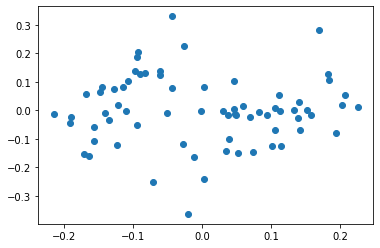

In [22]:
plt.scatter(x=clients_approx[:,0], y=clients_approx[:,1])

В целом, можем заметить 2 кластера, слева и справа

### Кластеризация

Далее будем работать с исходным набором данных (размерности 6). Возьмём данные после стандартизации, для меньшего числа ошибок

In [30]:
df = pd.DataFrame(z)
df

,0,1,2,3,4,5
0,1.373878,0.911524,-0.141019,1.413885,0.100003,-0.000144
1,0.500726,-0.070117,-0.876335,0.610867,-0.813070,-0.836134
2,-1.495050,-2.033399,-1.158374,-1.396677,-1.421785,-1.339742
3,0.126518,-0.070117,-0.423058,0.209358,-0.407260,-0.413103
4,0.251254,-0.070117,-1.178520,0.410113,-1.117428,-1.168515
...,...,...,...,...,...,...
65,0.001782,-1.051758,-1.460558,0.209358,-1.523238,-1.490825
66,-0.372426,-0.070117,1.813107,-0.392905,1.824697,1.812846
67,-0.746634,-1.051758,0.080583,-0.794414,-0.001449,0.009928
68,-0.746634,-1.051758,0.725243,-0.794414,0.607266,0.654547


Чтобы лучше понять устройство данных, построим гистограммы распределения всех прихнаков, а так же их попарные распределения:

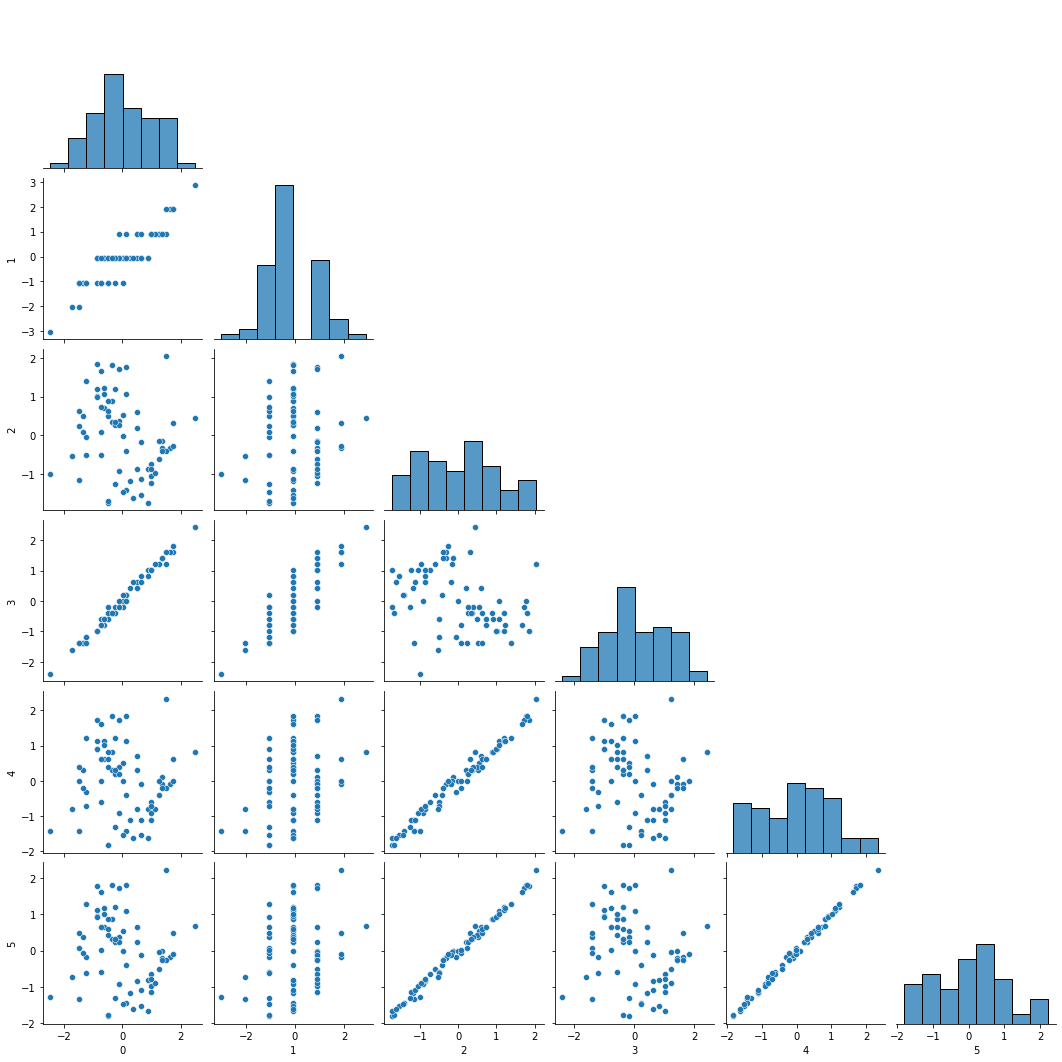

In [31]:
sns.pairplot(df, corner=True)

Во многих попарных распределениях видим кластерную структуру из 2 кластеров с шумом.

В качестве дистанции выберем Евклидово расстояние между точками, поскольку на обеих картинках выше мы используем Евклидову метрику и уже видим хорошую кластерную структуру. Нет смысла усложнять этот шаг. Матрицу близости (adjacency matrix) возьмём как матрицу расстояний, вычтенную из её наибольшего значения.

In [32]:
dist_x = distance_matrix(df, df, p=2)
adj_x = dist_x.max() - dist_x
adj_x

array([[9.68409548, 7.57598713, 4.21162391, ..., 6.03894407, 5.85473871,
        5.38285993],
       [7.57598713, 9.68409548, 6.13846004, ..., 7.07937285, 6.32271559,
        5.00510757],
       [4.21162391, 6.13846004, 9.68409548, ..., 6.98957447, 6.00595513,
        4.14292847],
       ...,
       [6.03894407, 7.07937285, 6.98957447, ..., 9.68409548, 8.58789542,
        6.74059775],
       [5.85473871, 6.32271559, 6.00595513, ..., 8.58789542, 9.68409548,
        7.73833194],
       [5.38285993, 5.00510757, 4.14292847, ..., 6.74059775, 7.73833194,
        9.68409548]])

In [34]:
dist_x

array([[0.        , 2.10810836, 5.47247157, ..., 3.64515142, 3.82935677,
        4.30123556],
       [2.10810836, 0.        , 3.54563545, ..., 2.60472264, 3.36137989,
        4.67898792],
       [5.47247157, 3.54563545, 0.        , ..., 2.69452101, 3.67814035,
        5.54116702],
       ...,
       [3.64515142, 2.60472264, 2.69452101, ..., 0.        , 1.09620006,
        2.94349773],
       [3.82935677, 3.36137989, 3.67814035, ..., 1.09620006, 0.        ,
        1.94576354],
       [4.30123556, 4.67898792, 5.54116702, ..., 2.94349773, 1.94576354,
        0.        ]])

В таком виде матрицу расстояний можно также назвать матрицей смежности для полного графа, вершинами которого являются точки из набора данных, а расстояние между точками определяет вес ребра. Поскольку все точки имеют конечные координаты, существует ребро между любой парой точек, а значит граф полный. В координатах $i, i$ находятся нули - граф не содержит петель. Евклидово расстояние коммутативно - граф неориентированный:

Создадим графовые структуры с помощью модуля `networkx`:

In [35]:
def create_graph(distances):
    G = nx.Graph()
    for i in range(distances.shape[0]):
        for j in range(distances.shape[1]):
            G.add_edge(i, j, weight=distances[i, j])
    return G

G_x = create_graph(adj_x)

#### Кластеризация на 2 кластера. Метод K-means

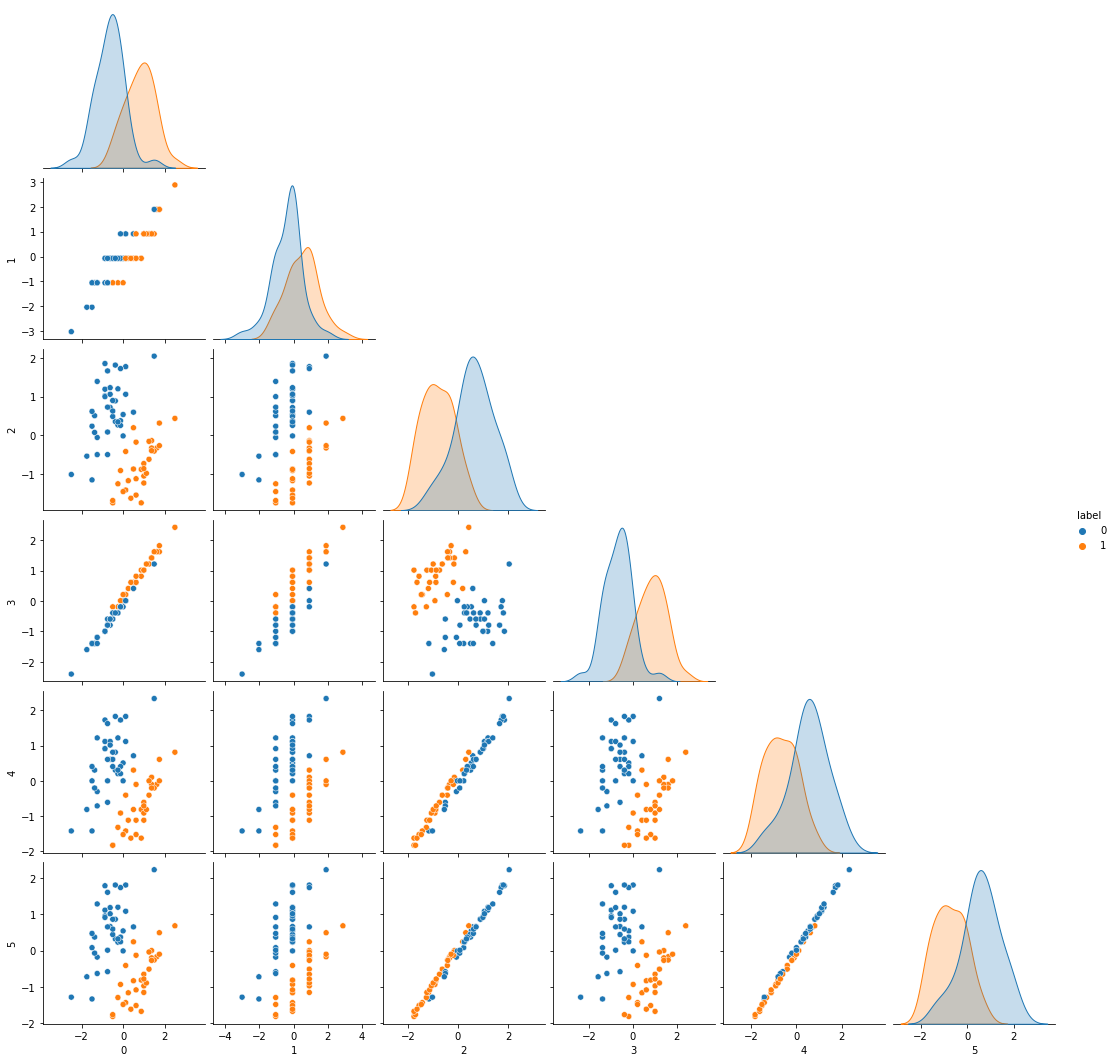

In [37]:
labels = {}

kmeans = KMeans(n_clusters=2, init="k-means++", n_init="auto",
                random_state=random_state, algorithm="lloyd").fit(df)
labels["kmeans"] = kmeans.labels_

plotting_df = df.copy()
plotting_df["label"] = labels["kmeans"]
sns.pairplot(plotting_df, corner=True, hue="label")

#### Кластеризация на 2 кластера. Метод спектральной кластеризации:

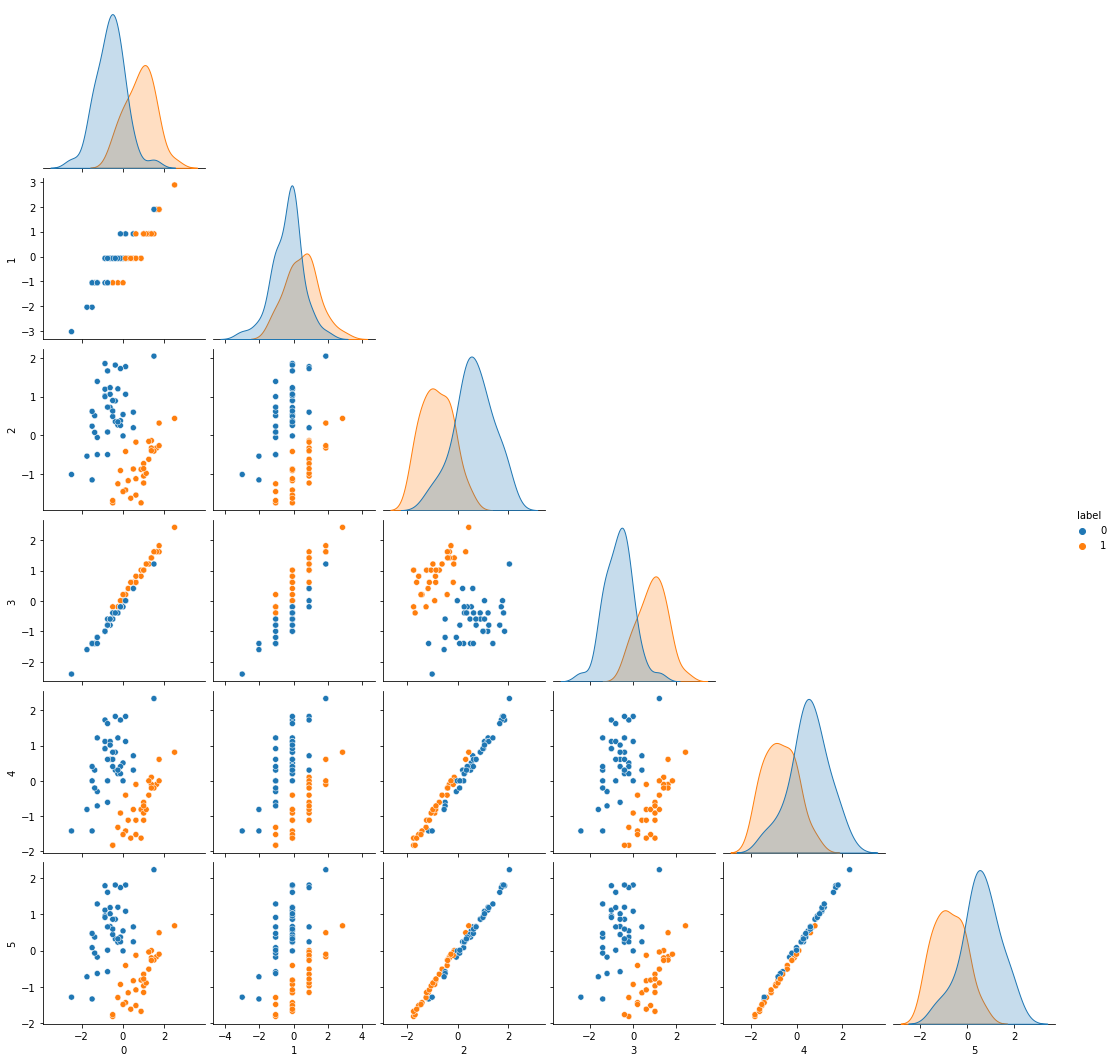

In [38]:
spectral = SpectralClustering(n_clusters=2, affinity="nearest_neighbors", random_state=random_state).fit(df)
labels["spectral"] = spectral.labels_

plotting_df = df.copy()
plotting_df["label"] = labels["spectral"]
sns.pairplot(plotting_df, corner=True, hue="label")

Оба метода разделили набор на 2 кластера. Внешне разделения кажутся аналогичными. Проверим это предположение с помощью RAND-index:

In [39]:
def compute_rand_index(labels_x, labels_y):
    if labels_x.shape[0] != labels_y.shape[0]:
        raise RuntimeError("Shapes must be equal")
    ab, cd = 0, 0
    for i in range(labels_x.shape[0]):
        for j in range(i+1, labels_x.shape[0]):
            if labels_x[i] == labels_x[j]:
                if labels_y[i] == labels_y[j]:
                    ab += 1
                else:
                    cd += 1
            else:
                if labels_y[i] == labels_y[j]:
                    cd += 1
                else:
                    ab += 1
    
    return (ab) / (ab + cd)

In [40]:
print(f'RAND index для K-means и Spectral: \
{compute_rand_index(labels["kmeans"], labels["spectral"]):.3f}')

RAND index для K-means и Spectral: 0.971


Действительно, разбиения получились очень похожими. RAND index (или accuracy в контексте кластеризации) практически равен единице.


Попытаемся оценить качество кластеризации с помощью индекса Дэвиса-Болдуина (Davies-Bouldin score). Данная метрика является очень популярной при оценке кластеризации. Меньшее значение означает лучшее разбиение.

In [41]:
print("Подсчет Davies-Bouldin score для разбиения на 2 кластера:")
print(f'K-means: \
{davies_bouldin_score(df, labels["kmeans"]):.3f}')
print(f'Spectral: \
{davies_bouldin_score(df, labels["spectral"]):.3f}')

Подсчет Davies-Bouldin score для разбиения на 2 кластера:
K-means: 0.961
Spectral: 0.959


Оба разбиения оказались достаточно неплохими с точки зрения метрики Davies-Bouldin score. Значение не превысило 1. Для обоих методов очень близкое, но всё-таки спектральный метод был оценён немного выше.


### Итог

 - В данных размерности 6 было найдено скрытых 2 признака, с помощью которых с минимальными потерями был возможен переход в размерность 2.
 - Оба использованных метода кластеризации справились с задачей и нашли кластерную структуру в данных
 - Использованная метрика показала, что разбиение на кластеры достаточно неплохое и мало отличается между алгоритмами